# Introduction
This notebook uses a Faster RCNN model trained with [this notebook](https://colab.research.google.com/drive/13KQoEpEG8vP76_OXHPJjgqI6lOxsaLxY#scrollTo=S557gOSdQgAi). A model of this type should therefore be downloaded to use this demo. A test model can be downloaded [here](https://drive.google.com/file/d/1eqj1dcnDcjguICUyLHNfflyZsmF3BNA9/view?usp=sharing)


To use this demo on the validation data set, following the structure of the training data, please structure the data as described in the training notebook linked above and run the data section of this notebook.

For a single image downloaded from e.g. Google, the data section (except the dictionaries to convert classes to labels and vice versa) can be skipped.

Below is code to mount your Google drive if running this code in colab.

In [1]:
# mount drive, this should be set to the folder where the data folder is stored
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd 'drive/My Drive/DTU/Deep learning/FoodRecognition' #must match tour own path to the directory where data is stored

/content/drive/My Drive/DTU/Deep learning/FoodRecognition


# Load necetities 

## Packages

In [3]:
import torchvision.datasets as datasets
import numpy as np
import torch
import torchvision.transforms as transforms
import os

from engine import train_one_epoch, evaluate
import utils
import transforms as T

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image, ImageDraw

## Data

In [18]:
# dicts for converting classes to labels
classes = ['__background__', 'boiled peas', 'boiled potatoes', 'chopped lettuce', 'fried egg',
        'glass of milk', 'glass of water', 'meatballs', 'plain rice', 'plain spaghetti',
        'slice of bread']

cls_to_label_dict = {j:i for i,j in enumerate(classes)}
label_to_cls_dict = {i:j for i,j in enumerate(classes)}

In [20]:
"""
Load data into a dataset class that can be used to train our model.
"""
torch.manual_seed(1)

class foodDataset(torch.utils.data.Dataset):
    """
    Class to store the food data
    """
    def __init__(self, data_root:str, datatype:str = "train", transforms = None):
      self.data_root = data_root
      self.transforms = transforms
      self.splitImgPath = data_root + "VOCdevkit/VOC2007/ImageSets/Main/" + datatype + ".txt"
      with open(self.splitImgPath, "r") as splitIdx:
        self.imgNames = splitIdx.readlines()

      # self.dataset = datasets.VOCDetection(data_root, year='2007', image_set = datatype, transform=self.transforms)
      self.dataset = datasets.VOCDetection(data_root, year='2007', image_set = datatype)

    def __getitem__(self, idx):
      img = self.dataset[idx][0]
      obs = self.dataset[idx][1]["annotation"]["object"]
      num_objs = len(obs)

      image_id = torch.tensor([int(os.path.splitext(self.dataset[idx][1]["annotation"]["filename"])[0])])

      boxes = []
      labels = torch.ones((num_objs,), dtype=torch.int64)
      for i in range(num_objs):
        xmin = int(obs[i]["bndbox"]["xmin"])
        xmax = int(obs[i]["bndbox"]["xmax"])
        ymin = int(obs[i]["bndbox"]["ymin"])
        ymax = int(obs[i]["bndbox"]["ymax"])
        boxes.append([xmin, ymin, xmax, ymax])
        cls = obs[i]["name"]
        try:
          labels[i] *= cls_to_label_dict[cls]
        except KeyError:
          raise KeyError(f"Image {image_id} had an unavailable label: {cls} ")
      boxes = torch.as_tensor(boxes, dtype=torch.float32)

      area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])

      # suppose all instances are not crowd
      iscrowd = torch.zeros((num_objs,), dtype=torch.int64)
      
      target = {}
      target["boxes"] = boxes
      target["labels"] = labels
      target["area"] = area
      target["image_id"] = image_id
      target["iscrowd"] = iscrowd

      return (img, target) if self.transforms is None else self.transforms(img, target)

    def __len__(self):
      return len(self.imgNames)


def get_transform(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(T.ToTensor())
    if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)
    
# use our dataset and defined transformations
root = "data/VOC/"
dataset_train = foodDataset(root, "train", get_transform(train=False))
dataset_test = foodDataset(root, "test", get_transform(train=False))
dataset_val = foodDataset(root, "val", get_transform(train=False))

# define training and validation data loaders
data_loader_train = torch.utils.data.DataLoader(
    dataset_train, batch_size=1, shuffle=False, num_workers=4,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=4,
    collate_fn=utils.collate_fn)

data_loader_val = torch.utils.data.DataLoader(
    dataset_val, batch_size=1, shuffle=False, num_workers=4,
    collate_fn=utils.collate_fn)

## Model

Please change path model, to match the path to where the model is stored


In [4]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f"Device used is: {device}")
model = torch.load("models/opt_model/model_epoch39.pth")
# evaluate(model, data_loader_val, device=device)

Device used is: cuda


# Prediction

## Plot functions

In [5]:
# Create figure, axes, and display the image
def show_img(img, target = None, prediction = None, score_threshold = 0.2, dist_threshold = 100, 
             pred_col = '#000000', trg_col = '#7f32a8', txt_col = 'white', savename = None):
  """
  Shows a test image with the boundary boxes and their labels
  -----------------------------------------------------------
  img: tensor with img values
  target: the target boundary box, typically obtained directly from dataset, if None the box will not be drawn
  prediction: the prediction obtained when giving the img to the model, if None the box will not be drawn
  score_threshold: a value set to sort out box predictions with low scores
  dist_threshold: a value set to sort out overlapping boxes by looking at the abosolute value of the difference between the box and boxes already found
  pred_col: color used to draw prediction box
  trg_col: color used to draw target box
  txt_col: color used for displaying the class
  savename: name used to save image with boxes, if None the iamge will not be saved
  """


  # Draw the bounding box: target
  def draw_target(target):
    for i in range(len(target["boxes"])):
      bbox = target["boxes"][i]
      left = bbox[0]
      top = bbox[1]
      width = bbox[2]-bbox[0]
      height = bbox[3]-bbox[1]
      rect = patches.Rectangle((left, top), width, height,linewidth=2,edgecolor=trg_col,facecolor='none')
      ax.add_patch(rect)

  def draw_prediction(prediction, score_thres = 0.2, dist_thres = 100):
    found = []
    boxes = prediction[0]["boxes"]
    for i in range(len(boxes)):
      if prediction[0]["scores"][i] < score_thres:
        break
      if i != 0:
        dist = []
        for j in range(len(found)):
          dist.append((boxes[i]-found[j]).abs().sum())
        if any(x < dist_thres for x in dist):
          break
      bbox = boxes[i]
      left = bbox[0]
      top = bbox[1]
      width = bbox[2]-bbox[0]
      height = bbox[3]-bbox[1]
      rect = patches.Rectangle((left, top), width, height,linewidth=2,edgecolor=pred_col,facecolor='none')
      label = "%s (%.3f)" % (label_to_cls_dict[prediction[0]["labels"][i].item()],prediction[0]["scores"][i])
      # print(label)
      plt.text(left, top-20, label, color=txt_col)
      ax.add_patch(rect)
      found.append(bbox)

  im = Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy())
  fig,ax = plt.subplots(1, figsize = (10, 10))
  ax.imshow(im)
  if target is not None:
    draw_target(target)
  if prediction is not None:
    draw_prediction(prediction, score_threshold, dist_threshold)
  if savename != None:
    plt.savefig(savename)

## Try single test image

### From validation set

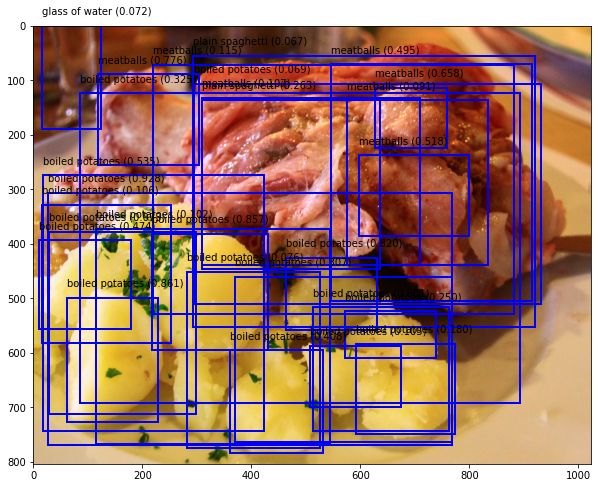

In [23]:
# pick one image from the test set (876, 842, 270, 296 used in report)
# img, target = dataset_val[876]
img, target = dataset_val[np.random.randint(0, len(dataset_val))] #get random image from validation set

# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])
# print("-"*25+"Prediction" + "-"*25)
# display(prediction)
# print("-"*25+"Target" + "-"*25)
# display(target)

# Show the bounding box
show_img(img, None, prediction, score_threshold = 0.7, dist_threshold = 24, txt_col = "black", pred_col = "blue", savename = None)
plt.show()

### Image from external sources

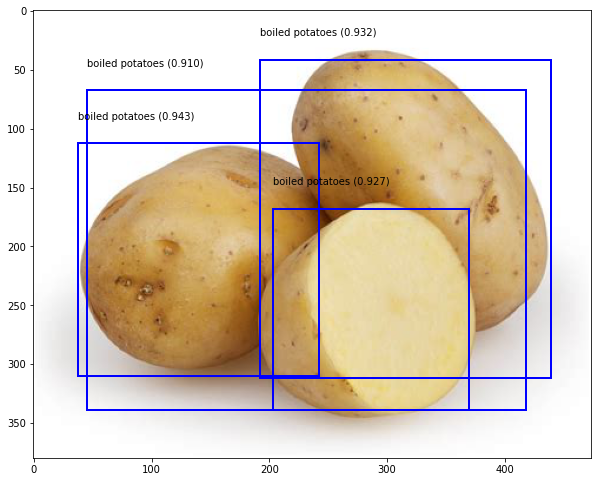

In [32]:
# load image and transform
img = Image.open("potato.jpg") #change to match own image
trans = transforms.ToTensor()
img = trans(img)

# predict
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])

show_img(img, None, prediction, score_threshold = 0.7, dist_threshold = 24, txt_col = "black", pred_col = "blue", savename = None)